### Speech Pipeline with Simulated Limitations

This script demonstrates a speech-to-speech conversational pipeline with explicit latency measurement and error simulation. It compares normal operation against scenarios with ASR information loss and transcription errors to highlight real-world system limitations.

Key Libraries Used:

    speech_recognition: Audio capture and Google ASR integration

    openai: Access to GPT-4o-mini LLM via API

    gtts: Text-to-speech conversion

    dotenv: Secure API key management

    time: Precise latency measurement

    random: Probabilistic error injection

Code Logic and Flow

The pipeline executes two distinct runs:

    Normal Run: Standard ASR → LLM → TTS flow

    Error Run: Deterministic Error Injector

    Always triggers during error runs

    Replaces key terms with unrelated words:

        Location names → Biological terms

        Temporal references → Animal anatomy

        Question words → Clothing items

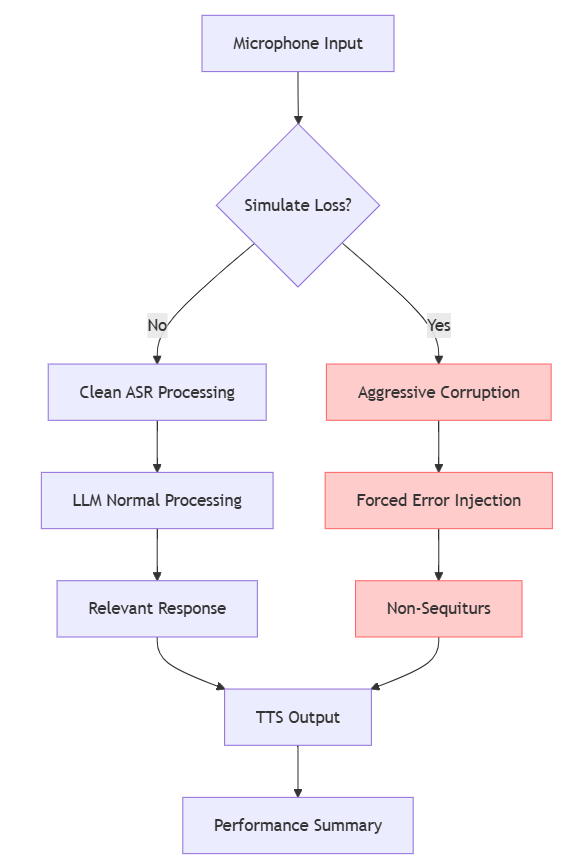

Step-by-Step Code Breakdown

1. ASR Processing with Loss Simulation

    Captures microphone input with ambient noise adjustment

    Optional information loss simulation: removes capitalization/punctuation

    Measures and returns ASR processing latency

2. Deterministic Error Injector

    Always triggers during error runs

    Replaces key terms with unrelated words:

        Location names → Biological terms

        Temporal references → Animal anatomy

        Question words → Clothing items

3. TTS Conversion and Playback

    Converts text to speech using Google's TTS

    Plays audio through system speakers

    Deletes temporary audio files

    Returns TTS processing time

4. Performance Summary Handling

    Creates comparative report for both runs

    Records transcribed text, LLM responses, and component latencies

    Appends metrics to summary file for analysis

    Prints full comparison at completion

5. Main Pipeline Execution

    Clears previous summary file

    Executes normal and error runs sequentially

    Aggregates latency measurements per component

    Generates final performance report

Connecting to Lecture Concepts

This implementation directly addresses core challenges in speech systems:

    Information Loss: Simulates ASR degradation through punctuation/capitalization removal

    Error Propagation: Demonstrates how transcription errors ("capital"→"capitol") misdirect LLMs

    Latency Measurement: Quantifies real-world delays in ASR/LLM/TTS components

    Cascading Failures: Shows error accumulation across pipeline stages

    Homophone Vulnerability: Highlights lexical sensitivity in speech recognition

    Quantitative Analysis: Provides comparable metrics for normal vs. degraded operation

    API Dependencies: Illustrates external service reliability impact on system performance   

In [ ]:
import speech_recognition as sr
import openai
from gtts import gTTS
import regex as re
import os
# from playsound import playsound
import pygame
import torch
print(torch.cuda.is_available())
print(torch.version.hip)
from dotenv import load_dotenv
import time
import random

# Load environment variables from .env file
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

# Initialize components
recognizer = sr.Recognizer()
output_file = "response.mp3"


def asr_process(simulate_loss=False):
    """Step 1: Automatic Speech Recognition (ASR)"""
    with sr.Microphone() as source:
        print("Listening for your query...")
        recognizer.adjust_for_ambient_noise(source)
        audio = recognizer.listen(source)
    
    start_time = time.time()
    try:
        text = recognizer.recognize_google(audio)
        print(f"Original Transcribed: {text}")
        if simulate_loss:
            # More aggressive information loss simulation
            text = text.lower()
            # Remove all punctuation and articles
            text = re.sub(r'[^\w\s]', '', text)
            text = re.sub(r'\b(the|a|an|in|to)\b', '', text)
            print(f"After Information Loss: {text}")
        latency = time.time() - start_time
        return text, latency
    except sr.UnknownValueError:
        print("Could not understand audio.")
        latency = time.time() - start_time
        return None, latency
    except sr.RequestError:
        print("ASR service error.")
        latency = time.time() - start_time
        return None, latency

def llm_process(text, simulate_error=False):
    """Step 2: Large Language Model (LLM) using OpenAI GPT-4o-mini"""
    start_time = time.time()
    if text:
        if simulate_error:
            # Always apply errors 
            error_map = {
                "weather": "leather",
                "capital": "cat pillow",
                "today": "toad eye",
                "city": "silly",
                "what": "hat",
                "paris": "parasite"
            }
            for correct, wrong in error_map.items():
                if correct in text.lower():
                    text = text.lower().replace(correct, wrong)
                    print(f"Simulated Transcription Error: {text}")
        
        prompt = f"User said: {text}. Respond concisely without asking for clarification."
        try:
            client = openai.OpenAI(api_key=openai_api_key)
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=50,
                n=1,
                stop=None,
                temperature=0.7,
            )
            response_text = response.choices[0].message.content.strip()
            print(f"LLM Response: {response_text}")
            latency = time.time() - start_time
            return response_text, latency
        except Exception as e:
            print(f"LLM API error: {e}")
            latency = time.time() - start_time
            return "Sorry, I couldn't process your request.", latency
    latency = time.time() - start_time
    return "Sorry, I didn't understand.", latency



def tts_process(text):
    """Step 3: Text-to-Speech (TTS)"""
    start_time = time.time()
    tts = gTTS(text=text, lang="en")
    tts.save(output_file)
    print("Playing response...")
    pygame.mixer.init()
    pygame.mixer.music.load(output_file)
    pygame.mixer.music.play()
    os.remove(output_file)
    latency = time.time() - start_time
    return latency

def save_summary(run_type, transcribed_text, response_text, latencies):
    """Save pipeline performance summary to a text file."""
    with open("pipeline_limitations_summary.txt", "a") as f:
        f.write(f"\n--- {run_type} Run ---\n")
        f.write(f"Transcribed Text: {transcribed_text}\n")
        f.write(f"LLM Response: {response_text}\n")
        f.write(f"ASR Latency: {latencies['asr']:.2f} seconds\n")
        f.write(f"LLM Latency: {latencies['llm']:.2f} seconds\n")
        f.write(f"TTS Latency: {latencies['tts']:.2f} seconds\n")
        f.write(f"Total Latency: {sum(latencies.values()):.2f} seconds\n")

def main_pipeline():
    """Run the full ASR + LLM + TTS pipeline to demonstrate limitations"""
    # Clear previous summary file
    if os.path.exists("pipeline_limitations_summary.txt"):
        os.remove("pipeline_limitations_summary.txt")
    
    # Normal Run
    print("\n=== Normal Run ===")
    transcribed_text, asr_latency = asr_process(simulate_loss=False)
    response_text, llm_latency = llm_process(transcribed_text, simulate_error=False)
    tts_latency = tts_process(response_text)
    latencies = {"asr": asr_latency, "llm": llm_latency, "tts": tts_latency}
    save_summary("Normal", transcribed_text, response_text, latencies)
    
    # Error Run (with information loss and transcription errors)
    print("\n=== Error Run ===")
    transcribed_text, asr_latency = asr_process(simulate_loss=True)
    response_text, llm_latency = llm_process(transcribed_text, simulate_error=True)
    tts_latency = tts_process(response_text)
    latencies = {"asr": asr_latency, "llm": llm_latency, "tts": tts_latency}
    save_summary("Error", transcribed_text, response_text, latencies)
    
    # Print summary
    print("\n=== Pipeline Limitations Summary ===")
    with open("pipeline_limitations_summary.txt", "r") as f:
        print(f.read())

if __name__ == "__main__":
    main_pipeline()

True
6.2.41133-dd7f95766

=== Normal Run ===


ALSA lib pcm_dsnoop.c:572:(snd_pcm_dsnoop_open) [error.pcm] unable to open slave
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) [error.pcm] unable to open slave
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadW

Listening for your query...
Original Transcribed: can you buy a ticket
LLM Response: I can't buy a ticket for you, but I can help guide you on how to do it.
Playing response...

=== Error Run ===


ALSA lib pcm_dsnoop.c:572:(snd_pcm_dsnoop_open) [error.pcm] unable to open slave
ALSA lib pcm_dmix.c:1000:(snd_pcm_dmix_open) [error.pcm] unable to open slave
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2722:(snd_pcm_open_noupdate) [error.pcm] Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadW

Listening for your query...
Could not understand audio.
Playing response...

=== Pipeline Limitations Summary ===

--- Normal Run ---
Transcribed Text: can you buy a ticket
LLM Response: I can't buy a ticket for you, but I can help guide you on how to do it.
ASR Latency: 0.47 seconds
LLM Latency: 1.42 seconds
TTS Latency: 0.52 seconds
Total Latency: 2.41 seconds

--- Error Run ---
Transcribed Text: None
LLM Response: Sorry, I didn't understand.
ASR Latency: 2.08 seconds
LLM Latency: 0.00 seconds
TTS Latency: 0.18 seconds
Total Latency: 2.26 seconds

